<a href="https://colab.research.google.com/github/ChungHanYang/Image-Stiching/blob/master/Image_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from scipy.linalg import solve
from scipy.linalg import lstsq
from scipy.linalg import qr
from scipy.spatial import distance
from numpy.linalg import svd
from math import sqrt
import cv2
from PIL import Image
import time


In [0]:
from google.colab import files
uploaded = files.upload()

Saving corners.mat to corners (1).mat
Saving keble_a.jpg to keble_a (1).jpg
Saving keble_b.jpg to keble_b (1).jpg
Saving keble_c.jpg to keble_c (1).jpg
Saving sift_features.mat to sift_features (3).mat


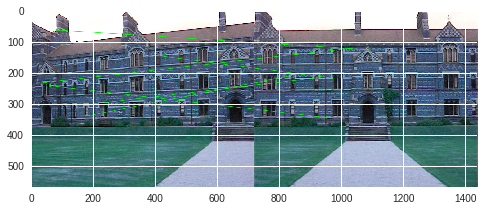

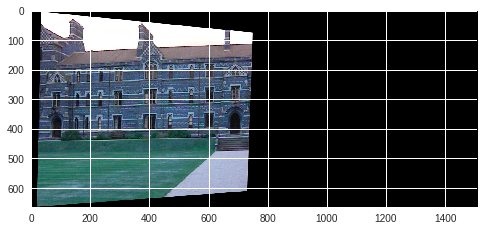

(664, 1510, 3)


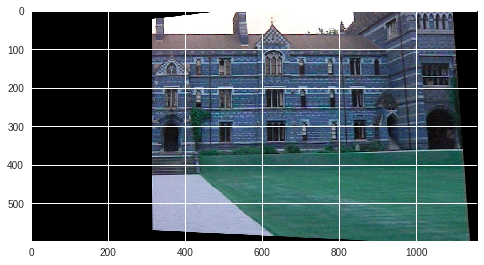

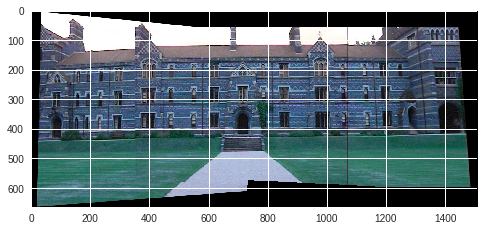

(<matplotlib.image.AxesImage at 0x7fd3eb7b9450>, None)

In [0]:
data_part1 = scipy.io.loadmat('corners (1).mat')
data_part2 = scipy.io.loadmat('sift_features (3).mat')

corners_center = data_part1['corners_center']
corners_right = data_part1['corners_right'] 
corners_left = data_part1['corners_left']
sift_center = data_part2['sift_center']
sift_right = data_part2['sift_right']
sift_left = data_part2['sift_left']

keble_left = cv2.imread('keble_a (1).jpg')
keble_center = cv2.imread('keble_b (1).jpg')
keble_right = cv2.imread('keble_c (1).jpg')

def computeH(im1_pts, im2_pts):
  im1_pts = np.transpose(im1_pts) 
  im2_pts = np.transpose(im2_pts)
  width, length = im1_pts.shape
  one = np.ones((len(width),), dtype=int)
  im1_pts = np.vstack(im1_pts,one)
  im2_pts = np.vstack(im2_pts,one)
  array1 = np.array([[-im1_pts[0][0], -im1_pts[1][0], -1, 0, 0, 0, im2_pts[0][0]*im1_pts[0][0], im2_pts[0][0]*im1_pts[1][0], im2_pts[0][0]],
                     [0, 0, 0, -im1_pts[0][0], -im1_pts[1][0], -1, im2_pts[1][0]*im1_pts[0][0], im2_pts[1][0]*im1_pts[1][0], im2_pts[1][0]]]) 
  array2 = np.array([[-im1_pts[0][1], -im1_pts[1][1], -1, 0, 0, 0, im2_pts[0][1]*im1_pts[0][1], im2_pts[0][1]*im1_pts[1][1], im2_pts[0][1]],
                     [0, 0, 0, -im1_pts[0][1], -im1_pts[1][1], -1, im2_pts[1][1]*im1_pts[0][1], im2_pts[1][1]*im1_pts[1][1], im2_pts[1][1]]]) 
  array3 = np.array([[-im1_pts[0][2], -im1_pts[1][2], -1, 0, 0, 0, im2_pts[0][2]*im1_pts[0][2], im2_pts[0][2]*im1_pts[1][2], im2_pts[0][2]],
                     [0, 0, 0, -im1_pts[0][2], -im1_pts[1][2], -1, im2_pts[1][2]*im1_pts[0][2], im2_pts[1][2]*im1_pts[1][2], im2_pts[1][2]]]) 
  array4 = np.array([[-im1_pts[0][3], -im1_pts[1][3], -1, 0, 0, 0, im2_pts[0][3]*im1_pts[0][3], im2_pts[0][3]*im1_pts[1][3], im2_pts[0][3]],
                     [0, 0, 0, -im1_pts[0][3], -im1_pts[1][3], -1, im2_pts[1][3]*im1_pts[0][3], im2_pts[1][3]*im1_pts[1][3], im2_pts[1][3]]]) 
  array = np.vstack(array1, array2, array3, array4)
  U,sigma,VT = svd(A)
  V = np.transpose(VT)
  h1 = V[0:3,-1]
  h2 = V[3:6,-1]
  h3 = V[6:9,-1]
  H = np.vstack((h1,h2,h3))
  return H

def euclidean(vector1, vector2):
    dist = [(a - b)**2 for a, b in zip(vector1, vector2)]
    dist = math.sqrt(sum(dist))
    return dist
  
orb = cv2.ORB_create() 
kp1, des1 = orb.detectAndCompute(keble_center,None)
kp2, des2 = orb.detectAndCompute(keble_left,None)
kp3, des3 = orb.detectAndCompute(keble_right,None)
  
bf = cv2.BFMatcher()
matches1 = bf.knnMatch(des1, des2, k=2)


good1 = []
for m,n in matches1:
    if m.distance < 0.45*n.distance:
        good1.append([m])
good2 = []
for m,n in matches1:
    if m.distance < 0.9*n.distance:
        good2.append(m)
        
draw_params = dict(matchColor = (0,255,1),
                   flags = 2)

img3 = cv2.drawMatchesKnn(keble_left, kp2, keble_center, kp1, good1, None, **draw_params)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good2])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good2])


plt.imshow(img3),plt.show()

h_cl, status1 = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5)
h_cl_inv = np.linalg.inv(h_cl)
# image offset (1)
ds = np.dot(h_cl_inv, np.array([keble_center.shape[1], keble_center.shape[0], 1]));
ds = ds/ds[-1]
f1 = np.dot(h_cl_inv, np.array([0,0,1]))
f1 = f1/f1[-1]
h_cl_inv[0][-1] += abs(f1[0])
h_cl_inv[1][-1] += abs(f1[1])
ds = np.dot(h_cl_inv, np.array([keble_center.shape[1], keble_center.shape[0], 1]))
offsety = abs(int(f1[1]))
offsetx = abs(int(f1[0]))
dsize = (int(ds[0])+offsetx+320, int(ds[1]) + offsety - 90)

im_out = cv2.warpPerspective(keble_left, h_cl_inv, dsize)
plt.imshow(im_out),plt.show()
print im_out.shape

bf2 = cv2.BFMatcher()
matches2 = bf2.knnMatch(des1,des3, k=2)

good3 = []
for m,n in matches2:
    if m.distance < 0.5*n.distance:
        good3.append(m)

pts3 = np.float32([kp1[m.queryIdx].pt for m in good3])
pts4 = np.float32([kp3[m.trainIdx].pt for m in good3])


h_cr, status2 = cv2.findHomography(pts3, pts4, cv2.RANSAC, 5)
h_cr_inv = np.linalg.inv(h_cr)
#image offset (2)
txyz = np.dot(h_cr_inv, np.array([keble_right.shape[1], keble_right.shape[0], 1]))
txyz = txyz/txyz[-1]
dsize2 = (int(txyz[0])+keble_center.shape[1]-700, int(txyz[1])+keble_center.shape[0]-580)

im_out2 = cv2.warpPerspective(keble_right, h_cr_inv, dsize2)
plt.imshow(im_out2),plt.show()

def match_left(leftImage, warpedImage):
		i1y, i1x = leftImage.shape[:2]
		for i in range(0, i1x):
			for j in range(0, i1y):
				try:
					if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
						warpedImage[j,i] = [0, 0, 0]
					else:
						if(np.array_equal(warpedImage[j,i],[0,0,0])):
							warpedImage[j,i] = leftImage[j,i]
						else:
							if not np.array_equal(leftImage[j,i], [0,0,0]):
								bw, gw, rw = warpedImage[j,i]
								bl,gl,rl = leftImage[j,i]
								warpedImage[j, i] = [bl,gl,rl]
				except:
					pass
		return warpedImage
def match_right(warpedImage, rightImage):
		for i in range(350,1510):
			for j in range(56, 674):
				try:
					if(np.array_equal(rightImage[j,i-350],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
						warpedImage[j,i] = [0, 0, 0]
					else:
						if(np.array_equal(warpedImage[j,i],[0,0,0])):
							warpedImage[j,i] = rightImage[j-56,i-350]
						else:
							if not np.array_equal(rightImage[j,i], [0,0,0]):
								bw, gw, rw = warpedImage[j,i]
								bl,gl,rl = rightImage[j-56,i-350]
								warpedImage[j, i] = [bl,gl,rl]
				except:
					pass
		return warpedImage

im_out3 = match_left(keble_center,im_out2)
im_out4 = match_right(im_out, im_out3)
plt.imshow(im_out4),plt.show()





     
